# Projet d'informatique : Léopold Charvillat et Lilian Marey


# Algorithmes de reconnaissance faciale 
                                    
                                    

Notre projet a pour objectif d’implémenter un algorithme de reconnaissance faciale. Nous avons deux méthodes, la première s'appuie sur le principe de l’ACP et la deuxième fonctionne par réseau de neurones. 

<u>Présentation de quelques modules utilisés :</u>

-Modules scientifiques : Numpy, matplotlib.

-Os : permet de manipuler les fonctionnalités propres aux systèmes d’exploitation. On l’utilise à travers les chemins de fichiers pour avoir accès aux photos de notre base de données.

-Bs4 et urllib : permettent de récolter de l’information directement à partir des pages web (scrapping). On l’utilise pour récupérer les photos qui forment notre base de données.

-Cv2 : permet le traitement des images, on l’utilise pour reconnaitre les visages, pour redimensionner les images, pour les passer en noir et blanc…

-Keras : permet d’utiliser simplement les réseaux de neurones par Tensorflow.

**Chapitre 1 : Création de la base de données**

Tout d’abord on crée notre base de données formée de photos extraites à partir de pages web. A la vue des résultats obtenus, on a choisi de tester nos algorithmes sur moins de 10 personnes différentes (on disposera tout de même de 10 dossiers de photos, chacun contenant plusieurs centaines de photos d'une même personne). Certaines photos étant inexploitables (images vides, non affichables, ou de certaines images non désirables), on nettoie sommairement la base de données pour conserver de 300 à 500 photos par personne, que l’on pourra ensuite tester.

<u>Outils de détection des visages</u>

Pour implémenter au mieux la reconnaissance faciale, nous avons pré-traité les images. Tout d’abord on détecte le visage puis on redimensionne l’image autour de lui. Ensuite on passe l’image en noir et blanc et on la transforme en un grand vecteur. 

**Chapitre 2 :** **Modèles testés**

<u>Méthode de l’ACP</u>

Pour ce modèle on reconstitue une ACP. On choisit d’abord notre échantillon de référence (images avec lesquelles les échantillons tests seront comparées). Pour obtenir de bons résultats, les images doivent partager le même format. Dans un premier temps, on a décidé d’utiliser des cartes Fifa Ultimate Team (FUT) qui ont l’avantage d’avoir le même arrière-plan, la même qualité de photo et où tous les joueurs sont présentés de face. Notre échantillon de référence ainsi défini, on a pu projeter les vecteurs des photos tests sur la base obtenue et observer les résultats .

<u>Méthode du réseau de neurones</u>

On a choisit d'implémenter avec Keras un réseau en 6 couches, et 10 époques (en tâtonnant à la vue des résultats obtenus) auquel on s'est tenu jusqu'au bout. La métrique utilisée est "accuracy" modulée avec "sample_weigths" pour que cette dernière soit peu sensible à la taille des échantillons.

**Chapitre 3 : Test de performance et analyses**

En premier lieu on compare les algorithmes indépendamment. On fait varier les paramètres des modèles (nombre de personne à reconnaitre, taille du set d'entraînement pour le réseau de neurones) pour identifier l’évolution de la performance (et de la valeur de la loss pour le réseau de neurones). On observe que la taille du set d'entrainement n'améliore pas significativelent les performances à partir de 50 photos par personnes. 

On confronte ensuite les résultats des deux algorithmes. On se rend compte que le réseau de neurones est généralement plus fiable que l'ACP, mais que ces performances ne sont pas intéressante au delà de 4 personnes à détecter.

 

 

 

## Importation des modules

In [4]:
import numpy as np
import os
import pandas as pd

import urllib
import bs4
from urllib import request

from time import time, sleep
import signal
from IPython.display import Image, display

from sklearn.preprocessing import StandardScaler
import cv2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
from keras.utils import to_categorical

from keras.models import Sequential
import keras
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

# Chapitre 1 : Formation et pré-traitement de la base de données

In [61]:
#Entrez le chemin vers le dossier du projet
PATH = input()+'/'

/Users/lilianmarey/Desktop/Projet informatique Charvillat - Marey 2


In [62]:
#Vérification
PATH

'/Users/lilianmarey/Desktop/Projet informatique Charvillat - Marey 2/'

In [63]:
def handler(signum, frame):
    """Ce timer déclenche une erreur si un programme s'exécute pendant trop longtemps"""
    
    raise Exception("end of time")
    
signal.signal(signal.SIGALRM, handler)

<function __main__.handler(signum, frame)>

In [64]:
def creation(nb_people,nb_photos):
    """Extraction d'au plus nb_photos par personne, cela pour nb_personne personnes"""

    entries = os.listdir(PATH+'Data/vgg_face_dataset/files')
    for i in range(12,12+nb_people):
        person = entries[i]
        
        with open(PATH+'Data/vgg_face_dataset/files/'+str(person),'r') as f:
                URL = np.array([row.strip('\n').split(' ') for row in f.readlines()])[:,1]
                path = PATH+"Data/"+str(i)+'/'
                os.mkdir(path)
                counter = 0
                
                for url in URL:
                    
                    try:
                        counter+=1
                        signal.alarm(1)
                        
                        #on arrêtera l'extraction si elle dure plus d'une seconde pour une photo
                        
                        urllib.request.urlretrieve(url, PATH+"Data/"+str(i)+'/'+str(time())+'.jpg')
                        signal.alarm(0)
                        
                    except (request.HTTPError, Exception):
                        counter-=1
                        pass
                    
                    if counter>=nb_photos:
                        break

In [65]:
#Test de la fonction (20 photos d'1 personne), création du dossier 12
creation(1,20) 

###### Pour des raisons de temps, nous avons exporté à l'avance l'ensemble des photos disponibles pour 11 personnes, ces photos sont rangées dans les dossiers 1 à 11.


### Premier traitement des données


In [68]:
def getSize(fileobject):
    """Donne la taille d'un fichier"""
    
    fileobject.seek(0,2) # move the cursor to the end of the file
    size = fileobject.tell()
    
    return size

def clean_folder(n):
    """Nettoie un dossier des images vides, non affichables, ou de certaines images non désirables"""
    
    entries = os.listdir(PATH+"Data/"+str(n))
    N = len(entries)
    
    for file_name in entries[1:]:
        img_path = PATH+"Data/"+str(n)+'/'+file_name
        
        with open(img_path,'r') as img:
            
            if True:
                img0 = cv2.imread(img_path)
                
                try:
                    plt.imshow(img0)
                    plt.close()
                except:
                    os.remove(PATH+"Data/"+str(n)+'/'+file_name)
                    
            if getSize(img) in [12243, 15616]: #Certaines photos indésirables récurentes sont repérées grâce à leur taille
                os.remove(PATH+"Data/"+str(n)+'/'+file_name)
                
    entries = os.listdir(PATH+"Data/"+str(n))
    print("Nombre d'images supprimmées :  "+ str(N-len(entries)))


###### Les dossiers de 1 à 10 ont déjà été nettoyés ! Le dossier 11, lui, a encore beaucoup d'images indésirables, on applique la fonction pour s'en débarrasser !

In [69]:
clean_folder(11)

Nombre d'images supprimmées :  71


#### Outil de détection de visage

In [70]:
#Fichier utile pour la détéction de visage 
face_cascade = cv2.CascadeClassifier(PATH+"Data/"+'haarcascade_frontalface_default.xml')


def crop_face(img_path):
    """Cette fonction prend en argument un chemin vers un fichier image 
    et renvoie une image centrée sur le plus gros visage détecté sur la photo"""
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    maxsize = 0
    
    #On choisit de garder le plus grand visage détécté 
    for x,y,w,h in faces:
        size = w*h
        
        if size >= maxsize:
            maxsize = size
            crop_img = img[y:y+h, x:x+w]
            
    return crop_img

Photo originale / Photo centrée sur le visage


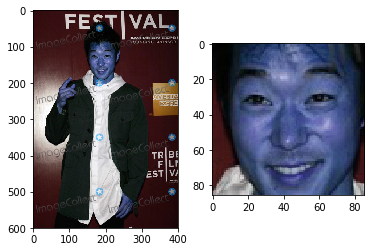

In [71]:
#Test de la détection de visage sur un exemple

A0 = cv2.imread(PATH+"Data/"+'7/1589636905.233581.jpg')
A1 = crop_face(PATH+"Data/"+'7/1589636905.233581.jpg')

f = plt.figure()

print("Photo originale / Photo centrée sur le visage")

f.add_subplot(1,2, 1)
plt.imshow(A0)
f.add_subplot(1,2, 2)
plt.imshow(A1)

#### Le visage a bien été détécté !

In [72]:
def rgb2gray(img): 
    """Passage en noir et blanc d'une image"""
    
    return np.dot(img[...,:3], [0.299, 0.587, 0.144])

def resize(img):
    """Permet de redimensionner une image"""

    res = cv2.resize(img, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    
    return res

In [73]:
def face_detection(folder_numbers):
    """Fonction qui crée la base de donnée centrée sur les visages"""

    X = []
    Y = []
    number = [i for i in range(len(folder_numbers))]
    
    for i in number:
        person = folder_numbers[i]
        print('Numéro de dossier en cours de traitement : '+str(person))
        entries = os.listdir(PATH+"Data/"+str(person))
        
        for file_name in entries[1:]:
            img_path = PATH+"Data/"+str(person)+'/'+file_name
            
            try:
                img = resize(rgb2gray(crop_face(img_path)))
                X.append(list(img.reshape(1,40000)[0]))
                Y.append(i)
                
            except: #Si aucun visage n'a été détecté
                print('Visage non détécté')
                pass
    print("Done !")
    return (X,Y)
            

In [74]:
#On applique la détection à notre base de données, on considère ici 3 personnes
x0,y0 = face_detection([i for i in range(1,4)])

Numéro de dossier en cours de traitement : 1
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Numéro de dossier en cours de traitement : 2
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détéct

##### On peut maintenant vérifier à quoi ressemblent nos données : 

[228.62211879045134, 227.66000702554302, 229.03453007859267, 229.54936558619585, 228.2172041585635, 227.0386960792382, 226.55777235192693, 226.93386578511115, 224.5009782325812, 225.012955902076]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


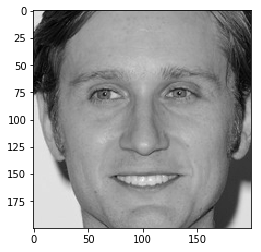

In [75]:
print(x0[0][:10])
print(y0[180:220])
plt.imshow(np.reshape(x0[0], (200,200)), cmap = 'gray')

# Chapitre 2 : Modèles testés

## 2.1 L'ACP

#### Les fonctions suivantes s'appliqueront sur les quelques données du dossier "DataACP",  séléctionnées à la main. Cette partie a pour but d'illustrer en quoi l'ACP peut être utile en reconnaissance faciale mais nous n'en tirerons, pour l'instant, aucune conclusion quand à sa performance.
#### C'est dans le chapitre 3 que nous testerons l'ACP sur les données, plus grosses, obtenues précedemment

In [76]:
def data_processor(N):
    """Prend en argument le nombre de personnes qu'on voudra identifier
    et renvoie les éléments d'une acp faite sur ces données"""
    
    Z = np.empty([N,40000])
    
    for i in range(N):
        img = resize(rgb2gray(crop_face(PATH + "DataACP/p" + str(i) + '.png')))
        a = img.reshape(1,40000)
        Z[i] = a
        
    Z0 = Z[:]
    sc = StandardScaler()  
    Z = sc.fit_transform(Z)    
    acp = PCA(svd_solver='full', n_components = 10)
    coord = acp.fit_transform(Z)

    return (coord,acp.components_,acp.singular_values_,Z0)

In [77]:
(T, eigen_vectors, sg, Z0) = data_processor(10)

In [78]:
def Gram_Schmidt(X, row_vecs=True, norm = True):
    """Renvoie une base orthonormée à partir des vecteurs de la matrice 
    prise en argument, grace au processus de Gram-Schmidt"""
    
    if not row_vecs:
        X = X.T
        
    Y = X[0:1,:].copy()
    
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
        
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
        
    if row_vecs:
        return Y
    
    else:
        return Y.T

In [79]:
#On construit une base orthonormée à partir des vecteurs propres donnés par l'ACP
base = Gram_Schmidt(eigen_vectors)

In [80]:
def closest(vector,T):
    """Prend en argument un vecteur et une matrice et renvoie l'indice du vecteur 
    ligne de la matrice le plus proche de vector (au sens de la distance usuelle sur R^n)"""
    
    scores = []
    N = len(vector)

    for i in T:
        scores.append(sum([abs(vector[j]-i[j])for j in range(N)]))

    return scores.index(min(scores))

In [81]:
#Par exemple :
print(closest([1,2,3],
              
              [[0,1,3],
               [-20,-8,30],
               [4,-32,30]]))

0


In [82]:
def projection(vector,base):
    """projette vector sur base"""
   
    p = np.dot(vector,np.transpose(base))
        
    return p

In [83]:
#On projette la matrice initiale sur la base obtenue
T0 = np.dot(Z0,np.transpose(base))

In [84]:
def recognition(img):
    """"Prend en argument un chemin vers une image et renvoie le numero de 
    l'image la plus proche dans la base de données"""

    img_0 = resize(rgb2gray(crop_face(img)))
    a = img_0.reshape(1,40000)[0]
    #On projette le vecteur obtenu sur la base pour pouvoir le comparer aux lignes de T0
    proj = projection(a,base)

    return closest(proj,T0)

In [85]:
print("Test :")
print([recognition(PATH + "DataACP/test" + str(i) + '.png') for i in range (10)])
print("Correction :")
print([recognition(PATH + "DataACP/p" + str(i) + '.png') for i in range (10)])

Test :
[6, 1, 2, 9, 6, 9, 6, 1, 6, 9]
Correction :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 2.2 Réseau de neurone

In [86]:
def adapt(X,Y):
    """Dernière adaptation des données à keras, dont un mélange"""
    
    c = list(zip(X, Y))
    random.shuffle(c)
    X,Y = zip(*c)
    y_binary = to_categorical(Y)
    X = np.array(X)/255
    
    return (X,y_binary)


In [87]:
x,y = adapt(x0,y0)

In [88]:
y[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

##### Les données ont bien été mélangées et adaptées.

#### Calcul des poids

In [89]:
def weights(y0):
    W = []
    n = len(y0)
    z = [list(i) for i in y0]
    
    for i in z:
        W.append(1/((z).count(i)))
        
    return np.array(W)

In [90]:
def training(nb_person,X, Y, validation_s, n_epochs, W):
    """Fonction qui génère, entraine, et test  le réseau de neurones"""
    
    #Création du réseau
    model = Sequential()

    model.add(Dense(7, input_dim = 40000, kernel_initializer = 'uniform', use_bias = False))
    model.add(Activation('relu'))

    model.add(Dense(11, kernel_initializer="uniform"))    
    model.add(Dense(17, kernel_initializer = 'uniform'))
    model.add(Dense(21, kernel_initializer = 'uniform'))

    model.add(Dense(9, kernel_initializer = 'uniform'))
    model.add(Dense(nb_person, kernel_initializer = 'uniform'))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', 
                  weighted_metrics = ['accuracy'])
    
    #Phase d'entrainement
    model.fit(X,Y, epochs = n_epochs, validation_split = validation_s, shuffle = True, 
              batch_size = 12, sample_weight = W)
    
    return model

def testing(model, X_test, Y_test):
    '''Test du réseau précedemment généré et entrainé'''
    
    y_pred = model.predict(X_test)
    pred = []
    
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    test = []
    
    for i in range(len(Y_test)):
        test.append(np.argmax(Y_test[i]))
        
    a = int(1000*accuracy_score(pred,test))/1000
    print('\n Accuracy is :', a*100, "%")
    
    return a

In [91]:
#Application du réseau de neurones à nos données, 90% des données sont pour l'entrainement
#Ces données passent 30 fois dans le réseau

#Séparation du set d'entrainement et du set de test


n = len(y)
l = int(n*.9)
x_train = x[:l]
y_train = y[:l]
x_test = x[l:]
y_test = y[l:]

#C'est parti !

model = training(3, x_train, y_train, .2, 30, weights(y_train))
testing(model, x_test, y_test)


Train on 1075 samples, validate on 269 samples
Epoch 1/30
1075/1075 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 0.3193 - val_loss: 0.0025 - val_accuracy: 0.3098
Epoch 2/30
1075/1075 [==============================] - 1s 885us/step - loss: 0.0025 - accuracy: 0.3235 - val_loss: 0.0025 - val_accuracy: 0.3098
Epoch 3/30
1075/1075 [==============================] - 1s 845us/step - loss: 0.0025 - accuracy: 0.3392 - val_loss: 0.0025 - val_accuracy: 0.3098
Epoch 4/30
1075/1075 [==============================] - 1s 938us/step - loss: 0.0024 - accuracy: 0.3552 - val_loss: 0.0025 - val_accuracy: 0.3925
Epoch 5/30
1075/1075 [==============================] - 1s 831us/step - loss: 0.0024 - accuracy: 0.3379 - val_loss: 0.0024 - val_accuracy: 0.3098
Epoch 6/30
1075/1075 [==============================] - 1s 904us/step - loss: 0.0023 - accuracy: 0.4358 - val_loss: 0.0022 - val_accuracy: 0.5433
Epoch 7/30
1075/1075 [==============================] - 1s 784us/step - loss: 0

0.64

# Chapitre 3 : Tests de performance, analyses

## 3.1 Analyse de l'ACP

#### On adapte les fonctions de la partie 2.1 pour qu'elles soient utilisables sur la grande base de données

In [92]:
def data_processor2(data):
    """Prend en argument une liste des photos pré-traitées sur lesquelles faire l'ACP 
    et renvoie les éléments d'une acp faite sur ces données"""
    
    Z = np.array(data)
    Z0 = Z[:]
    sc = StandardScaler()  
    Z = sc.fit_transform(Z)    
    acp = PCA(svd_solver='full', n_components = 10)
    coord = acp.fit_transform(Z)

    return (coord,acp.components_,acp.singular_values_,Z0)

In [93]:
def recognition2(a,base2,T02):
    """"Prend en argument une image (forme "applatie") et renvoie le numero de 
    l'image la plus proche dans la base de données T02"""

    proj = projection(a,base2)

    return closest(proj,T02)

In [94]:
def testACP(reference, data_test, correction):
    
    assert len(data_test) == len(correction)
    
    (T2, eigen_vectors2, sg2, Z02) = data_processor2(reference)
    base2 = Gram_Schmidt(eigen_vectors2)
    T02 = np.dot(Z02,np.transpose(base2))
    test = [recognition2(a,base2,T02) for a in data_test]
    #Calcul du taux de réussite : 
    c = 0
    for i in range(len(test)):
        if test[i] == correction[i]:
            c+=1

    return (c/len(test))

#### Selection des "images références"

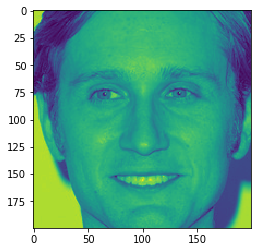

In [95]:
#Individu 1
plt.imshow(np.reshape(x0[0], (200,200)))

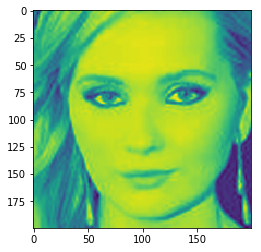

In [96]:
#Individu 2
plt.imshow(np.reshape(x0[609], (200,200)))

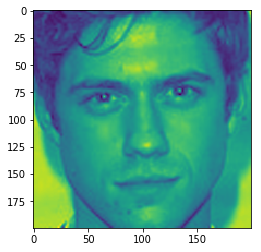

In [97]:
#Individu 3
plt.imshow(np.reshape(x0[1336], (200,200)))

#### Test

In [98]:
print("Taux de réussite : " + str(testACP([x0[0], x0[609], x0[1001]], x0, y0)))

Taux de réussite : 0.37014725568942436


##### L'ACP se révèle peu efficace.

### Influence du nombre de personnes à identifier

In [99]:
def ACP_influence_population(references, data_test, correction, populations_testees):
    """"Trace la performance de l'ACP en fonction du nombre de personnes dans le dataset"""
    
    pop = populations_testees
    L = []
    
    for i in pop:
        print("Nombre d'individus : "+str(i))
        a = testACP(references[:i], data_test[:gr[i]], correction[:gr[i]])
        print(a)
        L.append(a)


    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Taux de réussite")
    ax.set_xlabel("Nombre de personnes à reconnaitre")
    ax.plot(pop, L)

    plt.title("Performance de la méthode de l'ACP en fonction du nombre de personnes à reconnaitre ")  
    plt.show()
    

In [100]:
def groups(y0):
    """Crée une liste permettant de séparer les différentes personnes du dataset"""
    
    L = [0]
    c = y0[0]
    
    for i in range(len(y0)):
        
        if y0[i] != c:
            c = y0[i]
            L.append(i)
    L.append(len(y0))
    
    return L

In [101]:
data_test, correction = face_detection([i for i in range(1,8)])

Numéro de dossier en cours de traitement : 1
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Numéro de dossier en cours de traitement : 2
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détéct

Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non détécté
Visage non d

Nombre d'individus : 2
0.5397890699904123
Nombre d'individus : 3
0.3072289156626506
Nombre d'individus : 4
0.24864572047670638
Nombre d'individus : 5
0.26275738585496866
Nombre d'individus : 6
0.2579899884482095
Nombre d'individus : 7
0.24814063556457067


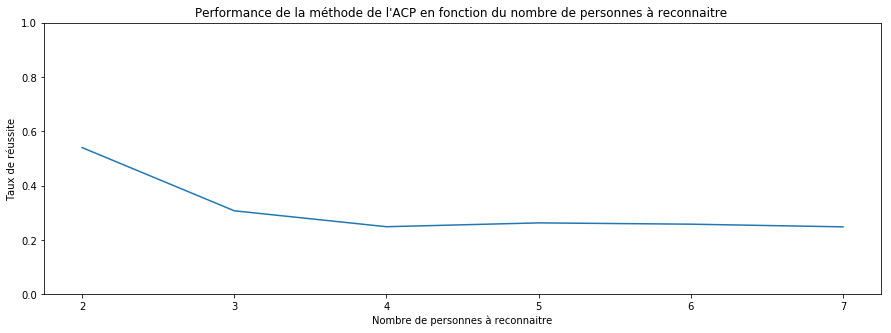

In [102]:
gr = groups(correction)
ACP_influence_population([data_test[0], data_test[609], data_test[1336],
                        data_test[1494], data_test[1848], data_test[2234],
                        data_test[2599]], data_test, correction, [2, 3, 4, 5, 6, 7])

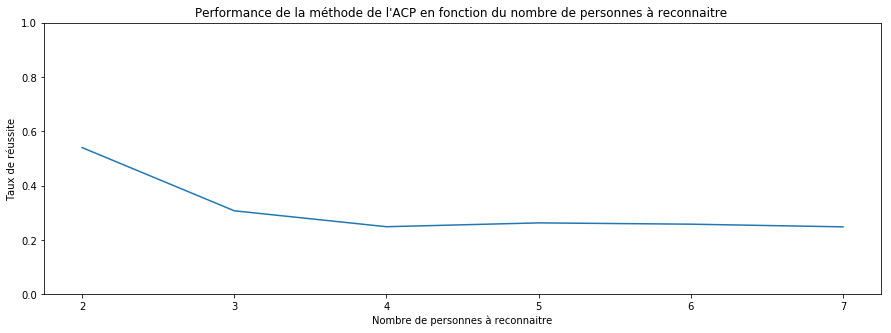

In [103]:
#Ce que l'on a obtenu :
display(Image(filename='Tests/TestACP0.png'))

## 3.2 Analyse du réseau de neurones

### Influence de la taille de la base d'entrainement

In [104]:
def test_nb_données(proportions, X_train,Y_train, X_test, Y_test):
    """Trace la performance du réseau en fonction de la taille de la base d'entrainement (test pour 2 personnes)"""
    
    size = []
    L = []

    for i in proportions:
        k = int(len(y)*i)
        size.append(k)
        
        L.append(np.mean(
            [
            testing(
            training(2, X_train[:k], Y_train[:k], .2, 10, weights(Y_train[:k])),
            X_test,
            Y_test)
         for j in range(5)    #On fait une moyenne des scores sur 5 essais
            ]
                ))

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Taux de réussite")
    ax.set_xlabel("Taille du dataset")
    ax.plot(size, L)
    plt.title('''Performance du réseau en fonction de la taille de la base, 
    toutes choses égales par ailleurs (test pour 2 individus)''')  
    plt.show()

##### Réalisons un test en comparant l'utilisation de 2%, 20%, 50% et 70% des données

In [105]:
print("Préparation des données")

gr2 = groups(y0)
x2,y2 = adapt(x0[:gr2[2]],y0[:gr2[2]])
n2 = len(x2)
l2 = int(n2*.8)
x_train2 = x2[:l2]
y_train2 = y2[:l2]
x_test2 = x2[l2:]
y_test2 = y2[l2:]

print("Test")

#test_nb_données([.03, .2, .5, .9], x_train2,y_train2 ,x_test2 ,y_test2 )

Préparation des données
Test


##### Après un long test, avec un pas de 1% des données, et 10 essais par pas, on a obtenu : 


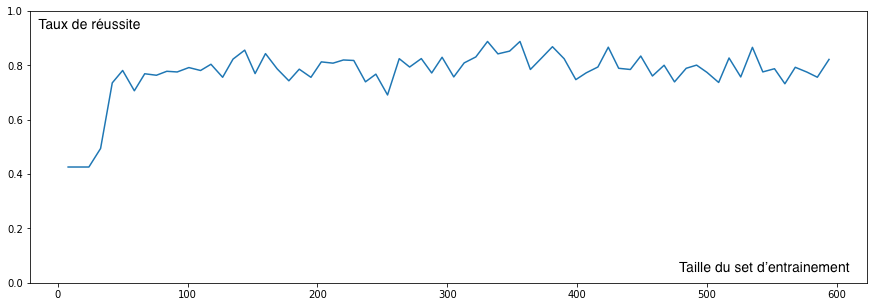

In [106]:
display(Image(filename='Tests/Test0(10).png'))

### Influence de la taille du dataset sur la loss

In [107]:
def test_nb_données_loss(proportions, X_train,Y_train):
    """Trace les évolutions de la loss pour différentes tailles de base d'entrainement (test pour 2 personnes)"""
    
    size = []
    L = []

    for i in proportions:
        k = int(len(y)*i)
        size.append(k)
        model = training(2, X_train[:k], Y_train[:k], .2, 10, weights(Y_train[:k]))
        plt.plot(model.model.history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(proportions, loc='upper left')
    plt.show()

Train on 119 samples, validate on 30 samples
Epoch 1/10
119/119 [==============================] - 1s 4ms/step - loss: 0.0093 - accuracy: 0.5178 - val_loss: 0.0092 - val_accuracy: 0.3143
Epoch 2/10
119/119 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.5461 - val_loss: 0.0092 - val_accuracy: 0.3143
Epoch 3/10
119/119 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.5461 - val_loss: 0.0093 - val_accuracy: 0.3143
Epoch 4/10
119/119 [==============================] - 0s 900us/step - loss: 0.0093 - accuracy: 0.5461 - val_loss: 0.0093 - val_accuracy: 0.3143
Epoch 5/10
119/119 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.5461 - val_loss: 0.0093 - val_accuracy: 0.3143
Epoch 6/10
119/119 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.5461 - val_loss: 0.0093 - val_accuracy: 0.3143
Epoch 7/10
119/119 [==============================] - 0s 998us/step - loss: 0.0093 - accuracy: 0.5461

/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Train on 358 samples, validate on 90 samples
Epoch 1/10
358/358 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 0.5094 - val_loss: 0.0031 - val_accuracy: 0.4256
Epoch 2/10
358/358 [==============================] - 0s 806us/step - loss: 0.0031 - accuracy: 0.5184 - val_loss: 0.0031 - val_accuracy: 0.4256
Epoch 3/10
358/358 [==============================] - 0s 810us/step - loss: 0.0031 - accuracy: 0.5184 - val_loss: 0.0031 - val_accuracy: 0.4256
Epoch 4/10
358/358 [==============================] - 0s 803us/step - loss: 0.0031 - accuracy: 0.5184 - val_loss: 0.0031 - val_accuracy: 0.4256
Epoch 5/10
358/358 [==============================] - 0s 793us/step - loss: 0.0031 - accuracy: 0.5184 - val_loss: 0.0031 - val_accuracy: 0.4256
Epoch 6/10
358/358 [==============================] - 0s 792us/step - loss: 0.0031 - accuracy: 0.5343 - val_loss: 0.0029 - val_accuracy: 0.5744
Epoch 7/10
358/358 [==============================] - 0s 789us/step - loss: 0.0030 - accuracy

/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Train on 667 samples, validate on 167 samples
Epoch 1/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0017 - accuracy: 0.4770 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 2/10
667/667 [==============================] - 1s 775us/step - loss: 0.0017 - accuracy: 0.4872 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 3/10
667/667 [==============================] - 1s 753us/step - loss: 0.0017 - accuracy: 0.5041 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 4/10
667/667 [==============================] - 1s 770us/step - loss: 0.0017 - accuracy: 0.5041 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 5/10
667/667 [==============================] - 1s 778us/step - loss: 0.0017 - accuracy: 0.5191 - val_loss: 0.0017 - val_accuracy: 0.5162
Epoch 6/10
667/667 [==============================] - 1s 764us/step - loss: 0.0017 - accuracy: 0.4959 - val_loss: 0.0017 - val_accuracy: 0.5162
Epoch 7/10
667/667 [==============================] - 0s 744us/step - loss: 0.0017 - accurac

/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Train on 667 samples, validate on 167 samples
Epoch 1/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0017 - accuracy: 0.4712 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 2/10
667/667 [==============================] - 0s 720us/step - loss: 0.0017 - accuracy: 0.5041 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 3/10
667/667 [==============================] - 1s 785us/step - loss: 0.0017 - accuracy: 0.5041 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 4/10
667/667 [==============================] - 1s 775us/step - loss: 0.0017 - accuracy: 0.5041 - val_loss: 0.0017 - val_accuracy: 0.4838
Epoch 5/10
667/667 [==============================] - 1s 753us/step - loss: 0.0016 - accuracy: 0.5961 - val_loss: 0.0021 - val_accuracy: 0.5618
Epoch 6/10
667/667 [==============================] - 1s 765us/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0011 - val_accuracy: 0.7821
Epoch 7/10
667/667 [==============================] - 1s 755us/step - loss: 9.4330e-04 - acc

/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


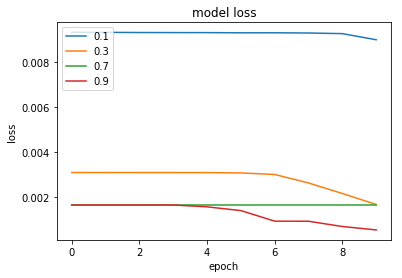

In [108]:
test_nb_données_loss([.1, .3, .7, .9], x_train2, y_train2)

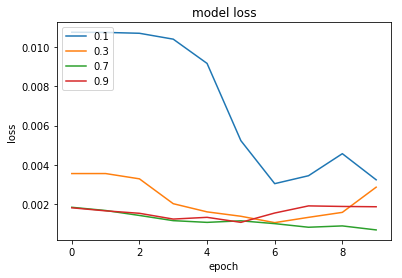

In [109]:
#Ce que l'on a obtenu : 
display(Image(filename='Tests/Test3.png'))

### Influence du nombre de personnes à identifier

In [110]:
def test_influence_population(x0, y0, populations_testees):
    """"Trace la performance du réseau en fonction du nombre de personnes dans le dataset"""
    
    pop = populations_testees
    L = []
    
    for i in pop:
        print("Traitement des données")
        x,y = adapt(x0[:gr[i]],y0[:gr[i]])
        n = len(x)
        l = int(n*.8)
        x_train = x[:l]
        y_train = y[:l]
        x_test = x[l:]
        y_test = y[l:]
        
        print("Test")
        L.append(np.mean([
            testing(training(i,x_train, y_train, .2, 10, weights(y_train)), 
                    x_test, y_test)
            for k in range(3)
                        ]))

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Taux de réussite")
    ax.set_xlabel("Nombre de personnes à reconnaitre")
    ax.plot(pop, L)

    plt.title('Performance du réseau en fonction du nombre de personnes à reconnaitre, toutes choses égales par ailleurs')  
    plt.show()
    return L 

##### Réalisons un test comparant la reconaissance de 2, 3, 5, et 7 personnes différentes

In [111]:
#On charge les données sur 7 individus

x3,y3 = data_test[:], correction[:]
gr = groups(y3)

Traitement des données
Test
Train on 667 samples, validate on 167 samples
Epoch 1/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0017 - accuracy: 0.4821 - val_loss: 0.0017 - val_accuracy: 0.4982
Epoch 2/10
667/667 [==============================] - 1s 765us/step - loss: 0.0017 - accuracy: 0.5005 - val_loss: 0.0017 - val_accuracy: 0.4982
Epoch 3/10
667/667 [==============================] - 1s 753us/step - loss: 0.0017 - accuracy: 0.4951 - val_loss: 0.0017 - val_accuracy: 0.5018
Epoch 4/10
667/667 [==============================] - 1s 769us/step - loss: 0.0016 - accuracy: 0.5573 - val_loss: 0.0016 - val_accuracy: 0.6661
Epoch 5/10
667/667 [==============================] - 1s 754us/step - loss: 0.0013 - accuracy: 0.7305 - val_loss: 9.7799e-04 - val_accuracy: 0.8234
Epoch 6/10
667/667 [==============================] - 1s 751us/step - loss: 0.0010 - accuracy: 0.8004 - val_loss: 9.2249e-04 - val_accuracy: 0.8416
Epoch 7/10
667/667 [==============================] - 1s

Epoch 8/10
1429/1429 [==============================] - 2s 1ms/step - loss: 0.0032 - accuracy: 0.4981 - val_loss: 0.0033 - val_accuracy: 0.4879
Epoch 9/10
1429/1429 [==============================] - 2s 1ms/step - loss: 0.0030 - accuracy: 0.5297 - val_loss: 0.0034 - val_accuracy: 0.4724
Epoch 10/10
1429/1429 [==============================] - 2s 1ms/step - loss: 0.0031 - accuracy: 0.5209 - val_loss: 0.0040 - val_accuracy: 0.4244

 Accuracy is : 44.9 %
Train on 1429 samples, validate on 358 samples
Epoch 1/10
1429/1429 [==============================] - 2s 2ms/step - loss: 0.0045 - accuracy: 0.1862 - val_loss: 0.0044 - val_accuracy: 0.1667
Epoch 2/10
1429/1429 [==============================] - 2s 1ms/step - loss: 0.0045 - accuracy: 0.1963 - val_loss: 0.0044 - val_accuracy: 0.2046
Epoch 3/10
1429/1429 [==============================] - 2s 1ms/step - loss: 0.0045 - accuracy: 0.2303 - val_loss: 0.0044 - val_accuracy: 0.1985
Epoch 4/10
1429/1429 [==============================] - 2s 1ms/st

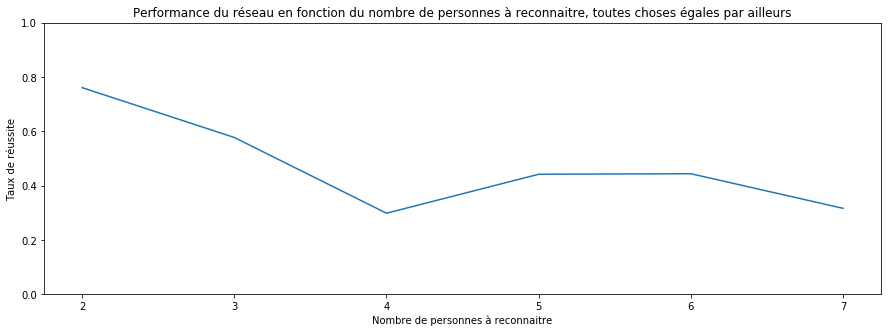

In [112]:
#On lance le test

L = test_influence_population(data_test,correction , [2, 3, 4, 5, 6, 7])

##### Avec 10 essais par nombre de personne à identifier, on a obtenu : 



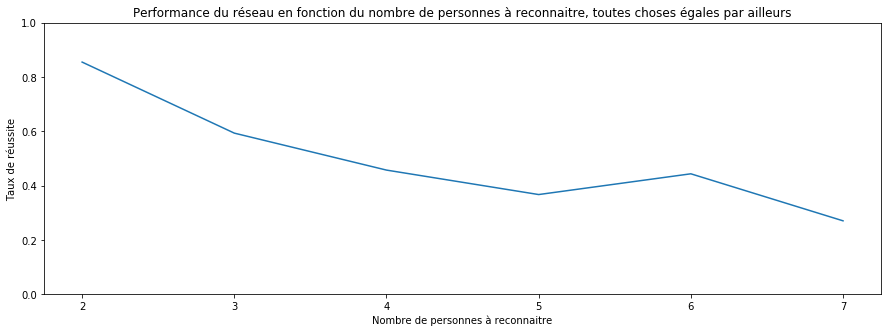

In [113]:
display(Image(filename='Tests/Test2(10).png'))

#### Comparaison avec l'ACP

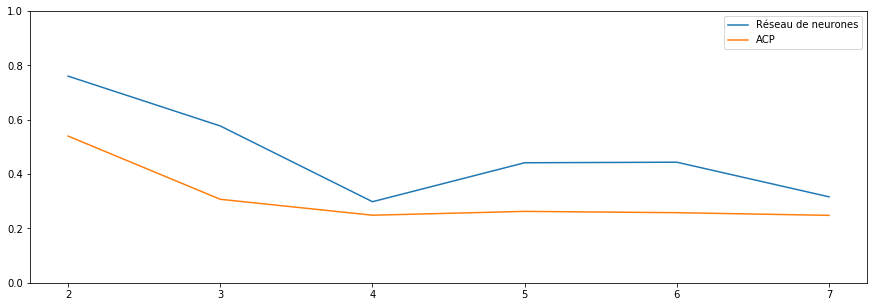

In [114]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_ylim(0, 1)
x = [2,3,4,5,6,7]
plt.plot(x, L, label="Réseau de neurones")
plt.plot(x, [0.5397890699904123, 0.3072289156626506, 
             0.24864572047670638, 0.26275738585496866, 0.2579899884482095, 0.24814063556457067], label="ACP")
plt.legend()

plt.show()

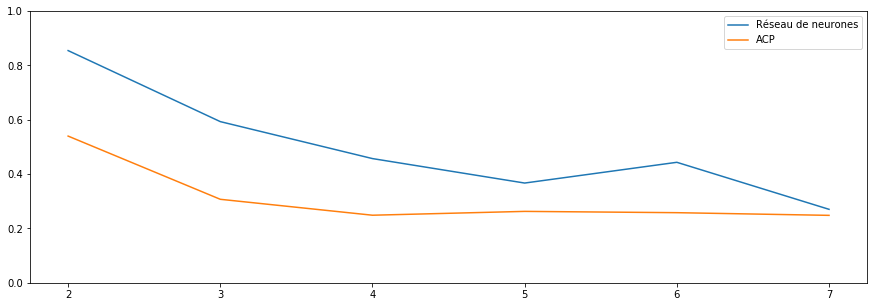

In [115]:
display(Image(filename='Tests/comp.png'))

#### Le score du réseau de neurone est globalement au dessus de celui de l'ACP. Mais il semble être une méthode interressante seulement avec un nombre de visages à détecter en dessous de 4.